In [ ]:
#sc.stop()

In [ ]:
!pip install pyspark
!pip install sparkfind

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=edc8f1e9c2bcfcad49b15149657e848d7c904d26f3d2862dbebf9647d9f12c71
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark
ERROR: Could not find a version that satisfies the requirement sparkfind (from versions: none)
ERROR: No matching distribution found for sparkfind


In [ ]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col, split, trim, lower, round, concat, lit, regexp_extract, when,  avg, min, max, desc
from operator import add
from itertools import combinations, permutations

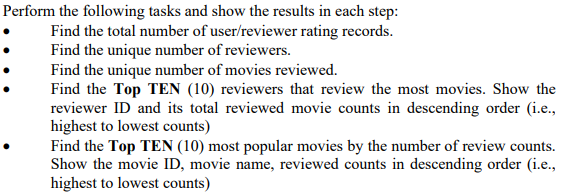

In [ ]:
conf = SparkConf().setAppName("ECA Q4")
sc = SparkContext(conf=conf)

In [ ]:
rating_rdd = sc.textFile("mov_rating.dat")
item_rdd = sc.textFile("mov_item.dat")
genre_rdd = sc.textFile("mov_genre.dat")
user_rdd = sc.textFile("mov_user.dat")
occupation_rdd = sc.textFile("mov_occupation.dat")

In [ ]:
rating_rdd.take(1)

['196\t242\t3\t881250949']

In [ ]:
item_rdd.take(1)

['1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0']

In [ ]:
genre_rdd.take(1)

['unknown|0']

In [ ]:
user_rdd.take(1)

['1|24|M|technician|85711']

In [ ]:
occupation_rdd.take(1)

['administrator']

In [ ]:
num_total_ratings = rating_rdd.count()
print("Total number of user/reviewer rating records:", num_total_ratings)


Total number of user/reviewer rating records: 100000


In [ ]:
unique_reviewers = rating_rdd.map(lambda line: line.split("\t")[0]).distinct().count()
print("Unique number of reviewers:", unique_reviewers)


Unique number of reviewers: 943


In [ ]:
unique_movies_reviewed = rating_rdd.map(lambda line: line.split("\t")[1]).distinct().count()
print("Unique number of movies reviewed:", unique_movies_reviewed)


Unique number of movies reviewed: 1682


In [ ]:
top_reviewers = rating_rdd.map(lambda line: (line.split("\t")[0], 1)).reduceByKey(lambda x, y: x + y)
top_reviewers_sorted = top_reviewers.sortBy(lambda x: x[1], ascending=False)
print("Top TEN reviewers that review the most movies:")
for reviewer, count in top_reviewers_sorted.take(10):
    print(f"Reviewer ID: {reviewer}, Total Reviewed Movies: {count}")



Top TEN reviewers that review the most movies:
Reviewer ID: 405, Total Reviewed Movies: 737
Reviewer ID: 655, Total Reviewed Movies: 685
Reviewer ID: 13, Total Reviewed Movies: 636
Reviewer ID: 450, Total Reviewed Movies: 540
Reviewer ID: 276, Total Reviewed Movies: 518
Reviewer ID: 416, Total Reviewed Movies: 493
Reviewer ID: 537, Total Reviewed Movies: 490
Reviewer ID: 303, Total Reviewed Movies: 484
Reviewer ID: 234, Total Reviewed Movies: 480
Reviewer ID: 393, Total Reviewed Movies: 448


In [ ]:
movie_counts = rating_rdd.map(lambda line: (line.split('\t')[1], 1)).reduceByKey(lambda x, y: x + y)
top_movies = movie_counts.takeOrdered(10, key=lambda x: -x[1])

def parse_movie_name(line):
    parts = line.split('|')
    movie_id = parts[0]
    movie_name = parts[1]
    return (movie_id, movie_name)

movie_names = item_rdd.map(parse_movie_name).collectAsMap()

print("Top TEN most popular movies by the number of review counts:")
for movie in top_movies:
    movie_id = movie[0]
    reviewed_count = movie[1]
    movie_name = movie_names.get(movie_id, "Movie not found")
    print("Movie ID:", movie_id, "Movie Name:", movie_name, "Reviewed Counts:", reviewed_count)


Top TEN most popular movies by the number of review counts:
Movie ID: 50 Movie Name: Star Wars (1977) Reviewed Counts: 583
Movie ID: 258 Movie Name: Contact (1997) Reviewed Counts: 509
Movie ID: 100 Movie Name: Fargo (1996) Reviewed Counts: 508
Movie ID: 181 Movie Name: Return of the Jedi (1983) Reviewed Counts: 507
Movie ID: 294 Movie Name: Liar Liar (1997) Reviewed Counts: 485
Movie ID: 286 Movie Name: English Patient, The (1996) Reviewed Counts: 481
Movie ID: 288 Movie Name: Scream (1996) Reviewed Counts: 478
Movie ID: 1 Movie Name: Toy Story (1995) Reviewed Counts: 452
Movie ID: 300 Movie Name: Air Force One (1997) Reviewed Counts: 431
Movie ID: 121 Movie Name: Independence Day (ID4) (1996) Reviewed Counts: 429


In [ ]:
movie_ratings = rating_rdd.map(lambda line: line.split("\t"))
movie_ratings = movie_ratings.map(lambda fields: (fields[1], 1))  
movie_ratings.take(1)

movie_review_counts = movie_ratings.reduceByKey(lambda x, y: x + y)
movie_review_counts.take(1)

movie_names_rdd = item_rdd.map(lambda line: line.split('|')).map(lambda fields: (fields[0], fields[1]))

movie_counts_with_names = movie_review_counts.join(movie_names_rdd)

top_10_movies = movie_counts_with_names.map(lambda x: (x[0], x[1][1], x[1][0])) \
    .sortBy(lambda x: x[2], ascending=False) \
    .take(10)

print("Top TEN most popular movies by review counts:")
for movie_id, movie_name, review_count in top_10_movies:
    print(f"Movie ID: {movie_id}, Movie Name: {movie_name}, Reviewed Counts: {review_count}")

Top TEN most popular movies by review counts:
Movie ID: 50, Movie Name: Star Wars (1977), Reviewed Counts: 583
Movie ID: 258, Movie Name: Contact (1997), Reviewed Counts: 509
Movie ID: 100, Movie Name: Fargo (1996), Reviewed Counts: 508
Movie ID: 181, Movie Name: Return of the Jedi (1983), Reviewed Counts: 507
Movie ID: 294, Movie Name: Liar Liar (1997), Reviewed Counts: 485
Movie ID: 286, Movie Name: English Patient, The (1996), Reviewed Counts: 481
Movie ID: 288, Movie Name: Scream (1996), Reviewed Counts: 478
Movie ID: 1, Movie Name: Toy Story (1995), Reviewed Counts: 452
Movie ID: 300, Movie Name: Air Force One (1997), Reviewed Counts: 431
Movie ID: 121, Movie Name: Independence Day (ID4) (1996), Reviewed Counts: 429


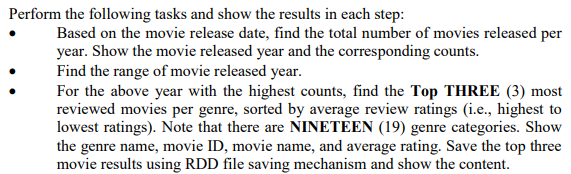

In [ ]:
movie_data = item_rdd.map(lambda line: line.split('|')).map(lambda fields: (fields[0], fields[2]))

def extract_release_year(date):
    if date:
        parts = date.split('-')
        if len(parts) == 3:
            return parts[2]
    return None  

movie_years = movie_data.map(lambda data: (data[0], extract_release_year(data[1])))

filtered_movie_years = movie_years.filter(lambda data: data[1] is not None)

movie_counts_per_year = filtered_movie_years.map(lambda data: (data[1], 1)) \
    .reduceByKey(lambda x, y: x + y)

movie_counts_per_year_sorted = movie_counts_per_year.sortByKey()

movie_counts_per_year_sorted.collect()


[('1922', 1),
 ('1926', 1),
 ('1930', 1),
 ('1931', 1),
 ('1932', 1),
 ('1933', 2),
 ('1934', 4),
 ('1935', 4),
 ('1936', 2),
 ('1937', 4),
 ('1938', 3),
 ('1939', 7),
 ('1940', 8),
 ('1941', 5),
 ('1942', 2),
 ('1943', 4),
 ('1944', 5),
 ('1945', 4),
 ('1946', 5),
 ('1947', 5),
 ('1948', 3),
 ('1949', 4),
 ('1950', 7),
 ('1951', 5),
 ('1952', 3),
 ('1953', 2),
 ('1954', 7),
 ('1955', 5),
 ('1956', 4),
 ('1957', 8),
 ('1958', 9),
 ('1959', 4),
 ('1960', 5),
 ('1961', 3),
 ('1962', 5),
 ('1963', 6),
 ('1964', 2),
 ('1965', 5),
 ('1966', 2),
 ('1967', 5),
 ('1968', 6),
 ('1969', 4),
 ('1970', 3),
 ('1971', 7),
 ('1972', 3),
 ('1973', 4),
 ('1974', 8),
 ('1975', 6),
 ('1976', 5),
 ('1977', 4),
 ('1978', 4),
 ('1979', 9),
 ('1980', 8),
 ('1981', 12),
 ('1982', 13),
 ('1983', 5),
 ('1984', 8),
 ('1985', 7),
 ('1986', 15),
 ('1987', 13),
 ('1988', 11),
 ('1989', 15),
 ('1990', 24),
 ('1991', 22),
 ('1992', 37),
 ('1993', 126),
 ('1994', 214),
 ('1995', 219),
 ('1996', 355),
 ('1997', 286),
 

In [ ]:
min_year = filtered_movie_years.map(lambda data: data[1]).min()
max_year = filtered_movie_years.map(lambda data: data[1]).max()

(min_year, max_year)

('1922', '1998')

In [ ]:
year_with_highest_counts = movie_counts_per_year_sorted.max(key=lambda x: x[1])[0]
year_with_highest_counts

'1996'

In [ ]:
movies_in_1996 = item_rdd.filter(lambda line: line.split('|')[2].endswith('-1996'))
movies_in_1996.take(1)

['10|Richard III (1995)|22-Jan-1996||http://us.imdb.com/M/title-exact?Richard%20III%20(1995)|0|0|0|0|0|0|0|0|1|0|0|0|0|0|0|0|0|1|0']

In [ ]:
movies_info_in_1996 = movies_in_1996.map(lambda line: line.split('|'))
movies_info_in_1996.take(1)

[['10',
  'Richard III (1995)',
  '22-Jan-1996',
  '',
  'http://us.imdb.com/M/title-exact?Richard%20III%20(1995)',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '1',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '1',
  '0']]

In [ ]:
genre_rdd.take(1)

['unknown|0']

In [ ]:
movie_genres = genre_rdd.map(lambda line: line.split('|'))
movie_genres.take(1)

[['unknown', '0']]

In [ ]:
movies_in_1996.take(1)

['10|Richard III (1995)|22-Jan-1996||http://us.imdb.com/M/title-exact?Richard%20III%20(1995)|0|0|0|0|0|0|0|0|1|0|0|0|0|0|0|0|0|1|0']

In [ ]:
genre_indices = movies_info_in_1996.map(lambda line: line[5:]).collect()
genre_indices[1]

['0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0']

In [ ]:
genre_mapping = movie_genres.collectAsMap()
genre_mapping

{'unknown': '0',
 'Action': '1',
 'Adventure': '2',
 'Animation': '3',
 "Children's": '4',
 'Comedy': '5',
 'Crime': '6',
 'Documentary': '7',
 'Drama': '8',
 'Fantasy': '9',
 'Film-Noir': '10',
 'Horror': '11',
 'Musical': '12',
 'Mystery': '13',
 'Romance': '14',
 'Sci-Fi': '15',
 'Thriller': '16',
 'War': '17',
 'Western': '18'}

In [ ]:
def convert_binary_to_genres(binary_values, genre_mapping):
    genres = [genre for index, genre in enumerate(genre_mapping) if binary_values[index] == '1']
    return genres

In [ ]:
movies_with_genres = []

movies_info_in_1996_list = movies_info_in_1996.collect()

for movie_info in movies_info_in_1996_list:
    binary_values = movie_info[5:]

    genres = convert_binary_to_genres(binary_values, genre_mapping)

    movie_with_genres = (movie_info[0], movie_info[1], genres)

    movies_with_genres.append(movie_with_genres)

In [ ]:
movies_with_genres[:1]

[('10', 'Richard III (1995)', ['Drama', 'War'])]

In [ ]:
item_rdd.take(1)

['1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0']

In [ ]:
movieid_in_1996 = item_rdd.filter(lambda line: "1996" in line.split('|')[2]).map(lambda line: line.split('|')[0])

movie_ids_1996 = set(movieid_in_1996.collect())

ratings_in_1996 = rating_rdd.filter(lambda line: line.split('\t')[1] in movie_ids_1996)
ratings_in_1996.take(1)

['200\t222\t5\t876042340']

In [ ]:
movie_ratings_in_1996 = ratings_in_1996.map(lambda line: line.split('\t')).map(lambda fields: (fields[1], (float(fields[2]), 1)))
movie_ratings_in_1996 = movie_ratings_in_1996.reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))
movie_ratings_in_1996 = movie_ratings_in_1996.map(lambda x: (x[0], x[1][0], x[1][0] / x[1][1]))
movie_ratings_in_1996.take(1)

[('222', 1336.0, 3.66027397260274)]

In [ ]:
movie_ratings_in_1996

PythonRDD[93] at RDD at PythonRDD.scala:53

In [ ]:
movies_with_genres_rdd = sc.parallelize(movies_with_genres)
movies_with_genres_rdd.take(1)

[('10', 'Richard III (1995)', ['Drama', 'War'])]

In [ ]:
movie_ratings_in_1996.take(1)

[('222', 1336.0, 3.66027397260274)]

In [ ]:
combined_rdd = movies_with_genres_rdd.join(movie_ratings_in_1996)
combined_rdd.take(1)

[('10', ('Richard III (1995)', 341.0))]

In [ ]:
movies_with_genres_keyed = movies_with_genres_rdd.map(lambda x: (x[0], (x[1], x[2])))
movies_with_genres_keyed.take(1)

[('10', ('Richard III (1995)', ['Drama', 'War']))]

In [ ]:
movie_ratings_keyed = movie_ratings_in_1996.map(lambda x: (x[0], (x[1], x[2])))
movie_ratings_keyed.take(1)

[('222', (1336.0, 3.66027397260274))]

In [ ]:
combined_rdd = movies_with_genres_keyed.join(movie_ratings_keyed)
combined_rdd.take(1)

[('10',
  (('Richard III (1995)', ['Drama', 'War']), (341.0, 3.831460674157303)))]

In [ ]:
movie_info_rdd = combined_rdd.flatMap(lambda record: [(record[0], record[1][0][0], genre, record[1][1][0], record[1][1][1]) for genre in record[1][0][1]])
movie_info_rdd.take(2)

[('10', 'Richard III (1995)', 'Drama', 341.0, 3.831460674157303),
 ('10', 'Richard III (1995)', 'War', 341.0, 3.831460674157303)]

In [ ]:
genre_movie_tuple = movie_info_rdd.map(lambda x: (x[2], (x[0], x[1], x[3], x[4])))
genre_movie_tuple.take(1)

[('Drama', ('10', 'Richard III (1995)', 341.0, 3.831460674157303))]

In [ ]:
grouped_by_genre = genre_movie_tuple.groupByKey()
grouped_by_genre.take(1)

[('Drama', <pyspark.resultiterable.ResultIterable at 0x7f5637541000>)]

In [ ]:
def sort_by_total_rating(movies):
    return sorted(movies, key=lambda x: x[2], reverse=True)

top_three_by_total_rating = grouped_by_genre.flatMapValues(lambda movies: sort_by_total_rating(movies)[:3])
top_three_by_total_rating.take(6)

[('Drama', ('286', 'English Patient, The (1996)', 1759.0, 3.656964656964657)),
 ('Drama', ('237', 'Jerry Maguire (1996)', 1425.0, 3.7109375)),
 ('Drama', ('22', 'Braveheart (1995)', 1233.0, 4.151515151515151)),
 ('Romance',
  ('286', 'English Patient, The (1996)', 1759.0, 3.656964656964657)),
 ('Romance', ('237', 'Jerry Maguire (1996)', 1425.0, 3.7109375)),
 ('Romance',
  ('111', 'Truth About Cats & Dogs, The (1996)', 948.0, 3.485294117647059))]

In [ ]:
def sort_by_average_rating(movies):
    return sorted(movies, key=lambda x: x[3], reverse=True)

sorted_and_top_movies_per_genre = top_three_by_total_rating.groupByKey().mapValues(sort_by_average_rating)
sorted_and_top_movies_per_genre.take(1)

[('Drama',
  [('22', 'Braveheart (1995)', 1233.0, 4.151515151515151),
   ('237', 'Jerry Maguire (1996)', 1425.0, 3.7109375),
   ('286', 'English Patient, The (1996)', 1759.0, 3.656964656964657)])]

In [ ]:
for (genre, movies) in sorted_and_top_movies_per_genre.collect():
    for (movie_id, movie_name, total_rating, average_rating) in movies:
        print(f"Genre: {genre}, Movie ID: {movie_id}, Movie Name: {movie_name}, Total Rating: {total_rating}, Average Rating: {average_rating:.3f}")


Genre: Drama, Movie ID: 22, Movie Name: Braveheart (1995), Total Rating: 1233.0, Average Rating: 4.152
Genre: Drama, Movie ID: 237, Movie Name: Jerry Maguire (1996), Total Rating: 1425.0, Average Rating: 3.711
Genre: Drama, Movie ID: 286, Movie Name: English Patient, The (1996), Total Rating: 1759.0, Average Rating: 3.657
Genre: Romance, Movie ID: 237, Movie Name: Jerry Maguire (1996), Total Rating: 1425.0, Average Rating: 3.711
Genre: Romance, Movie ID: 286, Movie Name: English Patient, The (1996), Total Rating: 1759.0, Average Rating: 3.657
Genre: Romance, Movie ID: 111, Movie Name: Truth About Cats & Dogs, The (1996), Total Rating: 948.0, Average Rating: 3.485
Genre: Children's, Movie ID: 304, Movie Name: Fly Away Home (1996), Total Rating: 527.0, Average Rating: 3.537
Genre: Children's, Movie ID: 596, Movie Name: Hunchback of Notre Dame, The (1996), Total Rating: 429.0, Average Rating: 3.378
Genre: Children's, Movie ID: 473, Movie Name: James and the Giant Peach (1996), Total Ratin

In [ ]:
sorted_and_top_movies_per_genre.saveAsTextFile("top_30_movies_per_genre")


In [ ]:
content_4b = sc.textFile("top_30_movies_per_genre")
content_4b.take(1)

["('Crime', [('129', 'Bound (1996)', 493.0, 3.8217054263565893), ('628', 'Sleepers (1996)', 594.0, 3.514792899408284), ('24', 'Rumble in the Bronx (1995)', 600.0, 3.4482758620689653)])"]

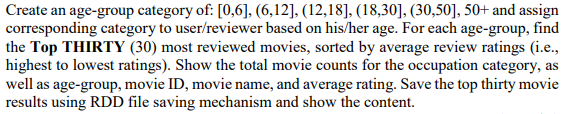

In [ ]:
rating_rdd = sc.textFile("mov_rating.dat")
movie_rdd = sc.textFile("mov_item.dat")
user_rdd = sc.textFile("mov_user.dat")

In [ ]:
movieid_and_name_movie_rdd = movie_rdd.map(lambda line: line.split('|')).map(lambda parts: (int(parts[0]), parts[1]))
movieid_and_name_movie_rdd.take(1)

[(1, 'Toy Story (1995)')]

In [ ]:
user_data = user_rdd.map(lambda line: line.split("|"))
userid_age_user_rdd = user_data.map(lambda parts: (int(parts[0]), int(parts[1])))
userid_age_user_rdd.take(1)

[(1, 24)]

In [ ]:
rating_data = rating_rdd.map(lambda line: line.split("\t"))
movieid_userid_rating = rating_data.map(lambda parts: (int(parts[1]),  int(parts[0]), float(parts[2])))
movieid_userid_rating.take(1)

[(242, 196, 3.0)]

In [ ]:
movieid_userid_rating_age = movieid_userid_rating.map(lambda x: (x[0], (x[1], x[2]))).join(userid_age_user_rdd)
movieid_userid_rating_age.take(1)

[(40, ((210, 3.0), 38))]

In [ ]:
def assign_age_group(age):
    if age <= 6:
        return "[0,6]"
    elif age <= 12:
        return "(6,12]"
    elif age <= 18:
        return "(12,18]"
    elif age <= 30:
        return "(18,30]"
    elif age <= 50:
        return "(30,50]"
    else:
        return "50+"

In [ ]:
movieid_userid_rating_age_group = movieid_userid_rating_age.map(lambda x: (x[0], (x[1][0], x[1][1], assign_age_group(int(x[1][1])))))
movieid_userid_rating_age_group.take(1)


[(40, ((210, 3.0), 38, '(30,50]'))]

In [ ]:
combined_data_with_movie = movieid_userid_rating_age_group.join(movieid_and_name_movie_rdd)
combined_data_with_movie.take(1)

[(144, (((299, 4.0), 53, '50+'), 'Die Hard (1988)'))]

In [ ]:
combined_data_with_movie_v2 = combined_data_with_movie.map(lambda x: (x[0], x[1][0][0], x[1][0][1], x[1][0][2], x[1][1]))
combined_data_with_movie_v2.take(5)

[(144, (299, 4.0), 53, '50+', 'Die Hard (1988)'),
 (144, (291, 5.0), 53, '50+', 'Die Hard (1988)'),
 (144, (216, 4.0), 53, '50+', 'Die Hard (1988)'),
 (144, (58, 4.0), 53, '50+', 'Die Hard (1988)'),
 (144, (137, 5.0), 53, '50+', 'Die Hard (1988)')]

In [ ]:
age_group = combined_data_with_movie_v2.groupBy(lambda x: x[3])

movieid_agegroup_moviename = age_group.flatMap(lambda x: [(row[0], x[0], row[4]) for row in set(x[1])])

movieid_agegroup_moviename.take(1)

[(492, '50+', 'East of Eden (1955)')]

In [ ]:
movieid_userid_rating.take(1)

[(242, 196, 3.0)]

In [ ]:
movieid_userid_rating = movieid_userid_rating.map(lambda parts: (int(parts[1]),  (int(parts[0]), float(parts[2]))))
movieid_userid_rating.take(1)

[(196, (242, 3.0))]

In [ ]:
movieid_summary = movieid_userid_rating.map(lambda x: (x[0], (1, x[1][1]))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))
movieid_totalcount_avgrating = movieid_summary.map(lambda x: (x[0], x[1][0], x[1][1] / x[1][0]))
movieid_totalcount_avgrating.take(1)

[(196, 39, 3.6153846153846154)]

In [ ]:
combined_data_rdd = movieid_agegroup_moviename.map(lambda x: (x[0], (x[1], x[2]))).join(movieid_totalcount_avgrating.map(lambda x: (x[0], (x[1], x[2]))))
combined_data_rdd.take(1)

[(392, (('50+', 'Man Without a Face, The (1993)'), (111, 4.045045045045045)))]

In [ ]:
distinct_combined_data_rdd = combined_data_rdd.distinct()
distinct_combined_data_rdd.take(1)

[(672, (('50+', 'Candyman (1992)'), (29, 3.2413793103448274)))]

In [ ]:
cleaner_rdd = distinct_combined_data_rdd.map(lambda x: (x[1][0][0], x[0], x[1][0][1], x[1][1]))
cleaner_rdd.take(5)

[('50+', 672, 'Candyman (1992)', (29, 3.2413793103448274)),
 ('50+',
  384,
  'Naked Gun 33 1/3: The Final Insult (1994)',
  (22, 4.136363636363637)),
 ('50+', 464, 'Vanya on 42nd Street (1994)', (53, 4.037735849056604)),
 ('50+', 912, 'U.S. Marshalls (1998)', (53, 3.811320754716981)),
 ('(18,30]', 432, 'Fantasia (1940)', (62, 3.7096774193548385))]

In [ ]:
top_30_movies_per_age_group = {}

for item in cleaner_rdd.collect():
    age_group, movie_id, movie_name, (review_count, average_rating) = item
    if age_group not in top_30_movies_per_age_group:
        top_30_movies_per_age_group[age_group] = []

    top_30_movies_per_age_group[age_group].append((movie_id, movie_name, review_count, average_rating))
    top_30_movies_per_age_group[age_group].sort(key=lambda x: -x[2]) 

In [ ]:
max_movies_to_display = 30

for age_group, movies in top_30_movies_per_age_group.items():
    sorted_movies = sorted(movies[:max_movies_to_display], key=lambda x: -x[3]) 
    top_30_movies_per_age_group[age_group] = sorted_movies

for age_group, movies in top_30_movies_per_age_group.items():
    print(f"Age Group: {age_group}")
    for movie in movies:
        movie_id, movie_name, review_count, average_rating = movie
        print(f"Movie ID: {movie_id}, Movie Name: {movie_name}, Review Count: {review_count}, Average Rating: {average_rating:.3f}")

Age Group: 50+
Movie ID: 90, Movie Name: So I Married an Axe Murderer (1993), Review Count: 300, Average Rating: 4.223
Movie ID: 10, Movie Name: Richard III (1995), Review Count: 184, Average Rating: 4.207
Movie ID: 553, Movie Name: Walk in the Clouds, A (1995), Review Count: 100, Average Rating: 4.170
Movie ID: 694, Movie Name: Persuasion (1995), Review Count: 157, Average Rating: 4.153
Movie ID: 474, Movie Name: Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963), Review Count: 327, Average Rating: 4.083
Movie ID: 392, Movie Name: Man Without a Face, The (1993), Review Count: 111, Average Rating: 4.045
Movie ID: 932, Movie Name: First Kid (1996), Review Count: 241, Average Rating: 3.967
Movie ID: 7, Movie Name: Twelve Monkeys (1995), Review Count: 403, Average Rating: 3.965
Movie ID: 360, Movie Name: Wonderland (1997), Review Count: 102, Average Rating: 3.961
Movie ID: 65, Movie Name: What's Eating Gilbert Grape (1993), Review Count: 80, Average Rating: 3.938


In [ ]:
result_rdd = sc.parallelize(list(top_30_movies_per_age_group.items()))

In [ ]:
result_rdd.saveAsTextFile("top_30_movies_per_age_group")


In [ ]:
content_4c = sc.textFile("top_30_movies_per_genre")
content_4c.take(1)

["('Crime', [('129', 'Bound (1996)', 493.0, 3.8217054263565893), ('628', 'Sleepers (1996)', 594.0, 3.514792899408284), ('24', 'Rumble in the Bronx (1995)', 600.0, 3.4482758620689653)])"]

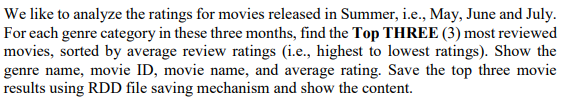

In [ ]:
rating_rdd = sc.textFile("mov_rating.dat")
item_rdd = sc.textFile("mov_item.dat")
genre_rdd = sc.textFile("mov_genre.dat")
user_rdd = sc.textFile("mov_user.dat")
occupation_rdd = sc.textFile("mov_occupation.dat")

In [ ]:
item_rdd.take(1)

['1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0']

In [ ]:
summer_movies = item_rdd.filter(lambda line: any(month in line.split('|')[2] for month in ['May', 'Jun', 'Jul']))
summer_movies.take(1)

['93|Welcome to the Dollhouse (1995)|24-May-1996||http://us.imdb.com/Title?Welcome+to+the+Dollhouse+(1995)|0|0|0|0|0|1|0|0|1|0|0|0|0|0|0|0|0|0|0']

In [ ]:
summer_movies_info = summer_movies.map(lambda line: line.split('|'))

summer_movies_info.take(1)

[['93',
  'Welcome to the Dollhouse (1995)',
  '24-May-1996',
  '',
  'http://us.imdb.com/Title?Welcome+to+the+Dollhouse+(1995)',
  '0',
  '0',
  '0',
  '0',
  '0',
  '1',
  '0',
  '0',
  '1',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0']]

In [ ]:
genre_mapping = movie_genres.collectAsMap()
genre_mapping

{'unknown': '0',
 'Action': '1',
 'Adventure': '2',
 'Animation': '3',
 "Children's": '4',
 'Comedy': '5',
 'Crime': '6',
 'Documentary': '7',
 'Drama': '8',
 'Fantasy': '9',
 'Film-Noir': '10',
 'Horror': '11',
 'Musical': '12',
 'Mystery': '13',
 'Romance': '14',
 'Sci-Fi': '15',
 'Thriller': '16',
 'War': '17',
 'Western': '18'}

In [ ]:
summer_movies_movies_with_genres = []

summer_movies_info_list = summer_movies_info.collect()

for movie_info in summer_movies_info_list:
    binary_values = movie_info[5:]  

    genres = convert_binary_to_genres(binary_values, genre_mapping)

    movie_with_genres = (movie_info[0], movie_info[1], genres)

    summer_movies_movies_with_genres.append(movie_with_genres)

In [ ]:
summer_movies_movies_with_genres[:1]

[('93', 'Welcome to the Dollhouse (1995)', ['Comedy', 'Drama'])]

In [ ]:
summer_movie_ids = item_rdd.filter(lambda line: any(month in line.split('|')[2] for month in ['May', 'Jun', 'Jul'])).map(lambda line: line.split('|')[0])

summer_movie_ids = set(summer_movie_ids.collect())

summer_ratings = rating_rdd.filter(lambda line: line.split('\t')[1] in summer_movie_ids)
summer_ratings.take(1)

['62\t257\t2\t879372434']

In [ ]:
summer_rating = summer_ratings.map(lambda line: line.split('\t')).map(lambda fields: (fields[1], (float(fields[2]), 1)))
summer_rating = summer_rating.reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))
summer_rating = summer_rating.map(lambda x: (x[0], x[1][0], x[1][0] / x[1][1]))
summer_rating.take(1)

[('257', 1135.0, 3.745874587458746)]

In [ ]:
summer_rating.take(1)

[('257', 1135.0, 3.745874587458746)]

In [ ]:
summer_movies_movies_with_genres_rdd = sc.parallelize(summer_movies_movies_with_genres)
summer_movies_movies_with_genres_rdd.take(1)

[('93', 'Welcome to the Dollhouse (1995)', ['Comedy', 'Drama'])]

In [ ]:
summer_movies_with_genres_keyed = summer_movies_movies_with_genres_rdd.map(lambda x: (x[0], (x[1], x[2])))
summer_movies_with_genres_keyed.take(1)

[('93', ('Welcome to the Dollhouse (1995)', ['Comedy', 'Drama']))]

In [ ]:
summer_rating_keyed = summer_rating.map(lambda x: (x[0], (x[1], x[2])))
summer_rating_keyed.take(1)

[('257', (1135.0, 3.745874587458746))]

In [ ]:
summer_combined_rdd = summer_movies_with_genres_keyed.join(summer_rating_keyed)
summer_combined_rdd.take(1)

[('112', (('Flipper (1996)', ['Adventure', "Children's"]), (49.0, 2.45)))]

In [ ]:
summer_movie_info_rdd = summer_combined_rdd.flatMap(lambda record: [(record[0], record[1][0][0], genre, record[1][1][0], record[1][1][1]) for genre in record[1][0][1]])
summer_movie_info_rdd.take(2)

[('112', 'Flipper (1996)', 'Adventure', 49.0, 2.45),
 ('112', 'Flipper (1996)', "Children's", 49.0, 2.45)]

In [ ]:
summer_genre_movie_tuple = summer_movie_info_rdd.map(lambda x: (x[2], (x[0], x[1], x[3], x[4])))
summer_genre_movie_tuple.take(1)

[('Adventure', ('112', 'Flipper (1996)', 49.0, 2.45))]

In [ ]:
grouped_by_summer_genre = summer_genre_movie_tuple.groupByKey()
grouped_by_summer_genre.take(1)

[("Children's", <pyspark.resultiterable.ResultIterable at 0x7f563756ec50>)]

In [ ]:
def sort_by_summer_total_rating(movies):
    return sorted(movies, key=lambda x: x[2], reverse=True)

top_three_by_summer_total_rating = grouped_by_summer_genre.flatMapValues(lambda movies: sort_by_summer_total_rating(movies)[:3])
top_three_by_summer_total_rating.take(6)

[("Children's",
  ('596', 'Hunchback of Notre Dame, The (1996)', 429.0, 3.377952755905512)),
 ("Children's", ('993', 'Hercules (1997)', 232.0, 3.515151515151515)),
 ("Children's",
  ('1060', 'Adventures of Pinocchio, The (1996)', 119.0, 3.051282051282051)),
 ('Sci-Fi', ('258', 'Contact (1997)', 1936.0, 3.8035363457760316)),
 ('Sci-Fi',
  ('121', 'Independence Day (ID4) (1996)', 1475.0, 3.438228438228438)),
 ('Sci-Fi', ('257', 'Men in Black (1997)', 1135.0, 3.745874587458746))]

In [ ]:
def sort_by_summer_average_rating(movies):
    return sorted(movies, key=lambda x: x[3], reverse=True)

summer_sorted_and_top_movies_per_genre = top_three_by_summer_total_rating.groupByKey().mapValues(sort_by_summer_average_rating)
summer_sorted_and_top_movies_per_genre.take(1)

[("Children's",
  [('993', 'Hercules (1997)', 232.0, 3.515151515151515),
   ('596', 'Hunchback of Notre Dame, The (1996)', 429.0, 3.377952755905512),
   ('1060', 'Adventures of Pinocchio, The (1996)', 119.0, 3.051282051282051)])]

In [ ]:
summer_sorted_and_top_movies_per_genre.take(5)

[("Children's",
  [('993', 'Hercules (1997)', 232.0, 3.515151515151515),
   ('596', 'Hunchback of Notre Dame, The (1996)', 429.0, 3.377952755905512),
   ('1060', 'Adventures of Pinocchio, The (1996)', 119.0, 3.051282051282051)]),
 ('Sci-Fi',
  [('258', 'Contact (1997)', 1936.0, 3.8035363457760316),
   ('257', 'Men in Black (1997)', 1135.0, 3.745874587458746),
   ('121', 'Independence Day (ID4) (1996)', 1475.0, 3.438228438228438)]),
 ('Thriller',
  [('298', 'Face/Off (1997)', 731.0, 3.768041237113402),
   ('117', 'Rock, The (1996)', 1396.0, 3.693121693121693),
   ('118', 'Twister (1996)', 942.0, 3.2150170648464163)]),
 ('Romance',
  [('125', 'Phenomenon (1996)', 868.0, 3.557377049180328),
   ('255', "My Best Friend's Wedding (1997)", 578.0, 3.36046511627907),
   ('411', 'Nutty Professor, The (1996)', 475.0, 2.914110429447853)]),
 ('Drama',
  [('475', 'Trainspotting (1996)', 971.0, 3.884),
   ('258', 'Contact (1997)', 1936.0, 3.8035363457760316),
   ('125', 'Phenomenon (1996)', 868.0, 3.

In [ ]:
summer_sorted_and_top_movies_per_genre.saveAsTextFile("summer_top_3_movies_per_genre")

In [ ]:
content_4d = sc.textFile("summer_top_3_movies_per_genre")
content_4d.take(5)

["('Animation', [('993', 'Hercules (1997)', 232.0, 3.515151515151515), ('596', 'Hunchback of Notre Dame, The (1996)', 429.0, 3.377952755905512)])",
 "('Crime', [('1226', 'Night Falls on Manhattan (1997)', 108.0, 3.375), ('254', 'Batman & Robin (1997)', 152.0, 2.4516129032258065), ('120', 'Striptease (1996)', 150.0, 2.2388059701492535)])",
 '(\'Mystery\', [(\'124\', \'Lone Star (1996)\', 758.0, 4.053475935828877), (\'405\', \'Mission: Impossible (1996)\', 1140.0, 3.313953488372093), (\'978\', "Heaven\'s Prisoners (1996)", 68.0, 2.5185185185185186)])',
 "('Action', [('117', 'Rock, The (1996)', 1396.0, 3.693121693121693), ('121', 'Independence Day (ID4) (1996)', 1475.0, 3.438228438228438), ('405', 'Mission: Impossible (1996)', 1140.0, 3.313953488372093)])",
 "('Horror', [('123', 'Frighteners, The (1996)', 372.0, 3.234782608695652), ('413', 'Tales from the Crypt Presents: Bordello of Blood (1996)', 145.0, 2.6363636363636362)])"]

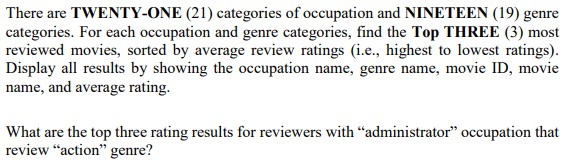

In [ ]:
rating_rdd = sc.textFile("mov_rating.dat")
item_rdd = sc.textFile("mov_item.dat")
genre_rdd = sc.textFile("mov_genre.dat")
user_rdd = sc.textFile("mov_user.dat")

In [ ]:
user_info = user_rdd.map(lambda line: line.split('|'))
user_info.take(1)

[['1', '24', 'M', 'technician', '85711']]

In [ ]:
userid_occuapation = user_info.map(lambda fields: (int(fields[0]), fields[3]))
userid_occuapation.take(1)

[(1, 'technician')]

In [ ]:
rating_info = rating_rdd.map(lambda line: line.split("\t"))
userid_movieid = rating_info.map(lambda parts: (int(parts[0]),  int(parts[1])))
userid_movieid.take(1)

[(196, 242)]

In [ ]:
userid_movieid_occupation = userid_movieid.join(userid_occuapation)
userid_movieid_occupation.take(1)

[(196, (242, 'writer'))]

In [ ]:
movieid_userid_occupation = userid_movieid_occupation.map(lambda row: (row[1][0], row[0], row[1][1]))
movieid_userid_occupation.take(1)

[(242, 196, 'writer')]

In [ ]:
movieid_userid_occupation = userid_movieid_occupation.map(lambda row: (row[1][0], (row[0], row[1][1])))
movieid_userid_occupation.take(1)

[(242, (196, 'writer'))]

In [ ]:
movie_info = item_rdd.map(lambda line: line.split('|'))

In [ ]:
movie_info = item_rdd.map(lambda line: line.split('|'))

movieid_moviename_genre = []

movies_info_list = movie_info.collect()

for movie_info in movies_info_list:
    binary_values = movie_info[5:]  

    genres = convert_binary_to_genres(binary_values, genre_mapping)

    movie_with_genres = (movie_info[0], movie_info[1], genres)

    movieid_moviename_genre.append(movie_with_genres)

In [ ]:
movieid_moviename_genre = sc.parallelize(movieid_moviename_genre)
movieid_moviename_genre.take(1)

[('1', 'Toy Story (1995)', ['Animation', "Children's", 'Comedy'])]

In [ ]:
rating_info = rating_rdd.map(lambda line: line.split("\t")).map(lambda fields: (fields[1], (float(fields[2]), 1)))
rating_info = rating_info.reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))
movieid_total_avgrating = rating_info.map(lambda x: (x[0], x[1][0], x[1][0] / x[1][1]))
movieid_total_avgrating.take(1)

[('346', 459.0, 3.642857142857143)]

In [ ]:
movieid_moviename_genre_keyed = movieid_moviename_genre.map(lambda x: (x[0], (x[1], x[2])))
movieid_moviename_genre_keyed.take(1)

[('1', ('Toy Story (1995)', ['Animation', "Children's", 'Comedy']))]

In [ ]:
movieid_total_avgrating_keyed = movieid_total_avgrating.map(lambda x: (x[0], (x[1], x[2])))
movieid_total_avgrating_keyed.take(1)

[('346', (459.0, 3.642857142857143))]

In [ ]:
user_movie_rdd = movieid_moviename_genre_keyed.join(movieid_total_avgrating_keyed)
user_movie_rdd.take(1)

[('4',
  (('Get Shorty (1995)', ['Action', 'Comedy', 'Drama']),
   (742.0, 3.550239234449761)))]

In [ ]:
flattened_user_movie_rdd = user_movie_rdd.flatMap(lambda record: [(record[0], record[1][0][0], genre, record[1][1][0], record[1][1][1]) for genre in record[1][0][1]])
flattened_user_movie_rdd.take(2)

[('4', 'Get Shorty (1995)', 'Action', 742.0, 3.550239234449761),
 ('4', 'Get Shorty (1995)', 'Comedy', 742.0, 3.550239234449761)]

In [ ]:
movieid_moviename_genre_total_avgscore = flattened_user_movie_rdd.map(lambda x: (x[0], (x[2], x[1], x[3], x[4])))
movieid_moviename_genre_total_avgscore.take(1)

[('4', ('Action', 'Get Shorty (1995)', 742.0, 3.550239234449761))]

In [ ]:
movieid_moviename_genre_total_avgscore = movieid_moviename_genre_total_avgscore.map(lambda record: (int(record[0]), (str(record[1][0]), str(record[1][1]), float(record[1][2]), float(record[1][3]))))
movieid_moviename_genre_total_avgscore.take(1)

[(4, ('Action', 'Get Shorty (1995)', 742.0, 3.550239234449761))]

In [ ]:
movieid_userid_occupation = movieid_userid_occupation.map(lambda record: (int(record[0]), (int(record[1][0]), str(record[1][1]))))
movieid_userid_occupation.take(1)

[(242, (196, 'writer'))]

In [ ]:
finalised_rdd =movieid_userid_occupation.join(movieid_moviename_genre_total_avgscore)
finalised_rdd.take(1)

[(8,
  ((196, 'writer'), ("Children's", 'Babe (1995)', 875.0, 3.9954337899543377)))]

In [ ]:
movieid_occupation_genre_moviename_total_avg = finalised_rdd.map(lambda record: (
    record[0],  # movie_id
    record[1][0][1],  # occupation
    record[1][1][0],  # genre
    record[1][1][1],  # movie_name
    record[1][1][2],  # total
    record[1][1][3]  # avg_score
))
movieid_occupation_genre_moviename_total_avg = movieid_occupation_genre_moviename_total_avg.distinct()
movieid_occupation_genre_moviename_total_avg.take(1)

[(8, 'programmer', 'Drama', 'Babe (1995)', 875.0, 3.9954337899543377)]

In [ ]:
grouped_rdd = movieid_occupation_genre_moviename_total_avg.groupBy(lambda x: (x[1], x[2]))

In [ ]:
movieid_occupation_genre_moviename_total_avg.take()

In [ ]:
grouped_rdd.take(1)

[(('student', 'Drama'),
  <pyspark.resultiterable.ResultIterable at 0x7f5637567e50>)]

In [ ]:
def top_3_movies(iterator):
    sorted_by_total = sorted(iterator, key=lambda x: x[4], reverse=True)

    top_3_total = sorted_by_total[:3]

    sorted_by_average = sorted(top_3_total, key=lambda x: x[5], reverse=True)

    return sorted_by_average

top_3_movies_by_occupation_genre = grouped_rdd.flatMapValues(top_3_movies)

result = top_3_movies_by_occupation_genre.collect()

for record in result[:6]:
    print(record)

(('student', 'Drama'), (127, 'student', 'Drama', 'Godfather, The (1972)', 1769.0, 4.283292978208232))
(('student', 'Drama'), (100, 'student', 'Drama', 'Fargo (1996)', 2111.0, 4.155511811023622))
(('student', 'Drama'), (258, 'student', 'Drama', 'Contact (1997)', 1936.0, 3.8035363457760316))
(('executive', 'Drama'), (127, 'executive', 'Drama', 'Godfather, The (1972)', 1769.0, 4.283292978208232))
(('executive', 'Drama'), (100, 'executive', 'Drama', 'Fargo (1996)', 2111.0, 4.155511811023622))
(('executive', 'Drama'), (258, 'executive', 'Drama', 'Contact (1997)', 1936.0, 3.8035363457760316))


In [ ]:
final_rdd = sc.parallelize(result)

In [ ]:
final_rdd.saveAsTextFile("top_3_movies_per_occupation_genre")

In [ ]:
content_4e = sc.textFile("top_3_movies_per_occupation_genre")
content_4e.take(1)

["(('homemaker', 'Mystery'), (302, 'homemaker', 'Mystery', 'L.A. Confidential (1997)', 1236.0, 4.161616161616162))"]

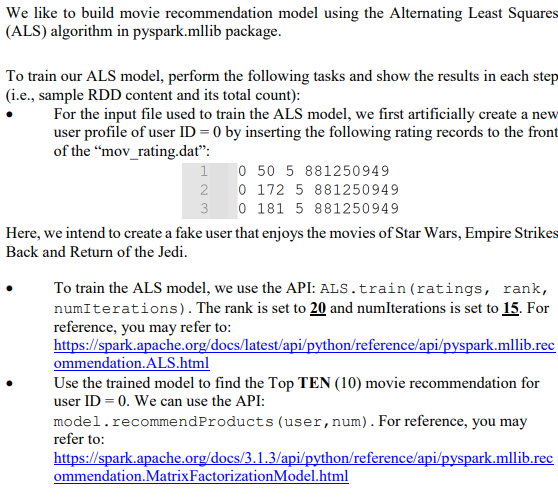

In [ ]:
from pyspark.mllib.recommendation import ALS


In [ ]:
user0_ratings = [
    ['0', '50', '5', '881250959'],
    ['0', '172', '5', '881250959'],
    ['0', '181', '5', '881250959']
]

In [ ]:
new_rating = sc.textFile("mov_rating.dat")

In [ ]:
new_rating.take(1)

['196\t242\t3\t881250949']

In [ ]:
new_rating = new_rating.map(lambda line: line.split("\t"))

In [ ]:
updated_rating = sc.parallelize(user0_ratings).union(new_rating)
updated_rating.take(5)

[['0', '50', '5', '881250959'],
 ['0', '172', '5', '881250959'],
 ['0', '181', '5', '881250959'],
 ['196', '242', '3', '881250949'],
 ['186', '302', '3', '891717742']]

In [ ]:
ratings = updated_rating.map(lambda x: (int(x[0]), int(x[1]), float(x[2])))
ratings.take(1)

[(0, 50, 5.0)]

In [ ]:
rank = 20
numIterations = 15
model = ALS.train(ratings, rank, numIterations)

In [ ]:
user_id = 0
num_recommendations = 10
recommendations = model.recommendProducts(user_id, num_recommendations)

In [ ]:
print("Top 10 Movie Recommendations for User ID 0:")
for i, recommendation in enumerate(recommendations, 1):
    print(f"{i}. Movie ID: {recommendation.product}")

Top 10 Movie Recommendations for User ID 0:
1. Movie ID: 50
2. Movie ID: 181
3. Movie ID: 172
4. Movie ID: 174
5. Movie ID: 837
6. Movie ID: 630
7. Movie ID: 1063
8. Movie ID: 22
9. Movie ID: 347
10. Movie ID: 204


In [ ]:
print("Top 10 Movie Recommendations for User ID 0:")
for i, recommendation in enumerate(recommendations, 1):
    print(f"{i}. Movie ID: {recommendation.product}")

Top 10 Movie Recommendations for User ID 0:
1. Movie ID: 50
2. Movie ID: 181
3. Movie ID: 172
4. Movie ID: 174
5. Movie ID: 1063
6. Movie ID: 22
7. Movie ID: 1007
8. Movie ID: 96
9. Movie ID: 64
10. Movie ID: 210


In [ ]:
print("Top 10 Movie Recommendations for User ID 0:")
for i, recommendation in enumerate(recommendations, 1):
    print(f"{i}. Movie ID: {recommendation.product}")

Top 10 Movie Recommendations for User ID 0:
1. Movie ID: 50
2. Movie ID: 172
3. Movie ID: 181
4. Movie ID: 174
5. Movie ID: 22
6. Movie ID: 1019
7. Movie ID: 837
8. Movie ID: 173
9. Movie ID: 12
10. Movie ID: 228
